# Práctica 4b
### Comparación entre Tesseract, SmolVLM y easyOCR

### Script para recorde de imágenes:

Con  nuestro modelo entrenado se recorre el dataset para obtener el bounding box de la matrícula y recortar la imagen y así quedarnos con solo las imágenes de las matrículas

In [ ]:
import os
import cv2
from ultralytics import YOLO
from pathlib import Path


def crop_and_save_detections(
    model_path,
    input_dir,
    output_dir,
    conf_threshold=0.5,
    class_filter=None,
    save_empty_images=False
):
    
    model = YOLO(model_path)
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    if save_empty_images:
        no_detection_path = output_path / "sin_detecciones"
        no_detection_path.mkdir(exist_ok=True)
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.heic', '.HEIC', '.webp'}
    
    input_path = Path(input_dir)
    image_files = [
        f for f in input_path.iterdir() 
        if f.suffix.lower() in valid_extensions and len(f.stem.split("_" )) == 1
    ]
    
    stats = {
        'total_images': len(image_files),
        'images_with_detections': 0,
        'images_without_detections': 0,
        'total_crops': 0,
        'crops_per_class': {}
    }
    
    # Procesar cada imagen
    for idx, image_file in enumerate(image_files, 1):
        img = cv2.imread(str(image_file))
        
        if img is None:
            print(f"Error al leer: {image_file.name}")
            continue
        
        results = model.predict(
            img,
            conf=conf_threshold,
            classes=class_filter,
            save=False,
            verbose=False
        )
        
        detections = results[0].boxes
        num_detections = len(detections)
        
        # Si no hay detección alguna
        if num_detections == 0:
            stats['images_without_detections'] += 1
            
            if save_empty_images:
                output_file = no_detection_path / image_file.name
                cv2.imwrite(str(output_file), img)
            
            print(f"[{idx}/{len(image_files)}] {image_file.name}: 0 detecciones")
            continue
        
        stats['images_with_detections'] += 1
        
        for det_idx, box in enumerate(detections):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            cls_id = int(box.cls[0].item())
            
            if x2 <= x1 or y2 <= y1:
                continue
            
            crop = img[y1:y2, x1:x2]
            
            if crop.size == 0:
                continue
            
            name_without_ext = image_file.stem
            crop_filename = f"{name_without_ext}.jpg"
            crop_path = output_path / crop_filename
            
            cv2.imwrite(str(crop_path), crop)
            
            stats['total_crops'] += 1
            stats['crops_per_class'][cls_id] = stats['crops_per_class'].get(cls_id, 0) + 1
        
        print(f"[{idx}/{len(image_files)}] {image_file.name}: {num_detections} detecciones → {num_detections} recortes guardados")
    
    print("\n" + "=" * 70)
    print("RESUMEN DEL PROCESAMIENTO")
    print("=" * 70)
    print(f"Total de imágenes procesadas:     {stats['total_images']}")
    print(f"Imágenes CON detecciones:         {stats['images_with_detections']}")
    print(f"Imágenes SIN detecciones:         {stats['images_without_detections']}")
    print(f"Total de recortes guardados:      {stats['total_crops']}")
    print("\nRecortes por clase:")
    for cls_id, count in sorted(stats['crops_per_class'].items()):
        print(f"  Clase {cls_id}: {count} recortes")
    print("=" * 70)
    
    return stats

In [ ]:
stats = crop_and_save_detections(
    model_path="runs/detect/license_plate_augmented/weights/best.pt",
    input_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset/train/images",
    output_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset_matriculas_recortadas",
    conf_threshold=0.5  
)

stats = crop_and_save_detections(
    model_path="runs/detect/license_plate_augmented/weights/best.pt",
    input_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset/val/images",
    output_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset_matriculas_recortadas",
    conf_threshold=0.5 
)

## Métricas comparación entre Tessercat y SmolVLM

In [ ]:
import os
import cv2
import time
import pytesseract
import torch
from pathlib import Path
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import pandas as pd
import re


class OCRComparator:
    
    def __init__(self, tesseract_path=None):
    
        if tesseract_path:
            pytesseract.pytesseract.tesseract_cmd = tesseract_path
        
        print("Cargando modelo SmolVLM...")
        self.processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
        self.model = AutoModelForVision2Seq.from_pretrained(
            "HuggingFaceTB/SmolVLM-Instruct",
            torch_dtype=torch.float16,
            device_map="auto",
            offload_folder="./offload",
            offload_state_dict=True
        )
        print("SmolVLM cargado correctamente\n")
        
        self.smolvlm_prompt = "Extract the license plate number from this image. Return only the alphanumeric characters, no spaces or special characters."
    
    def normalize_plate_text(self, text):
        if not text:
            return ""
        
        text = text.upper().strip()
        text = re.sub(r'[^A-Z0-9]', '', text)
        
        return text
    
    def ocr_tesseract(self, image_path):
        start_time = time.time()
        
        try:
            img = cv2.imread(str(image_path))
            
            if img is None:
                return None, 0
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
            
            text = pytesseract.image_to_string(img_rgb, config=custom_config)
            
            text = self.normalize_plate_text(text)
            
            elapsed_time = time.time() - start_time
            
            return text, elapsed_time
        
        except Exception as e:
            print(f"Error en Tesseract con {image_path.name}: {e}")
            return None, 0
    
    def ocr_smolvlm(self, image_path):
        start_time = time.time()
        
        try:
            image = Image.open(image_path).convert('RGB')
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": self.smolvlm_prompt}
                    ]
                }
            ]
            
            prompt = self.processor.apply_chat_template(messages, add_generation_prompt=True)
            inputs = self.processor(
                text=prompt,
                images=[image],
                return_tensors="pt"
            )
            
            # Mover a GPU si es que está disponible
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                generated_ids = self.model.generate(
                    **inputs,
                    max_new_tokens=50,
                    do_sample=False
                )
            
            generated_ids_trimmed = [
                out_ids[len(in_ids):] 
                for in_ids, out_ids in zip(inputs['input_ids'], generated_ids)
            ]
            
            output_text = self.processor.batch_decode(
                generated_ids_trimmed,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=False
            )[0]
            
            text = self.normalize_plate_text(output_text)
            
            elapsed_time = time.time() - start_time
            
            return text, elapsed_time
        
        except Exception as e:
            print(f"Error en SmolVLM con {image_path.name}: {e}")
            return None, 0
    
    def calculate_accuracy_metrics(self, predicted, ground_truth):
        
        if predicted is None or ground_truth is None:
            return {
                'exact_match': False,
                'char_accuracy': 0.0,
                'levenshtein_distance': float('inf')
            }
        
        pred = self.normalize_plate_text(predicted)
        gt = self.normalize_plate_text(ground_truth)
        
        exact_match = (pred == gt)
        
        if len(gt) == 0:
            char_accuracy = 1.0 if len(pred) == 0 else 0.0
        else:
            matches = sum(1 for p, g in zip(pred, gt) if p == g)
            char_accuracy = matches / max(len(pred), len(gt))
        
        lev_dist = self.levenshtein_distance(pred, gt)
        
        return {
            'exact_match': exact_match,
            'char_accuracy': char_accuracy,
            'levenshtein_distance': lev_dist
        }
    
    @staticmethod
    def levenshtein_distance(s1, s2):
        if len(s1) < len(s2):
            return OCRComparator.levenshtein_distance(s2, s1)
        
        if len(s2) == 0:
            return len(s1)
        
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    def compare_ocr_methods(self, images_dir, output_csv="ocr_comparison_results.csv"):
    
        images_path = Path(images_dir)
        valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
        image_files = [
            f for f in images_path.iterdir() 
            if f.suffix.lower() in valid_extensions
        ]
        
        print(f"Encontradas {len(image_files)} imágenes en {images_dir}")
        print(f"Iniciando comparativa OCR...\n")
        print("=" * 80)
        
        results = []
        
        for idx, img_file in enumerate(image_files, 1):
            ground_truth = img_file.stem
            
            print(f"\n[{idx}/{len(image_files)}] Procesando: {img_file.name}")
            print(f"  Ground Truth: {ground_truth}")
            
            print("Tesseract...", end=" ")
            tess_text, tess_time = self.ocr_tesseract(img_file)
            tess_metrics = self.calculate_accuracy_metrics(tess_text, ground_truth)
            print(f"✓ ({tess_time:.3f}s) → {tess_text}")
            
            print("SmolVLM...", end=" ")
            smol_text, smol_time = self.ocr_smolvlm(img_file)
            smol_metrics = self.calculate_accuracy_metrics(smol_text, ground_truth)
            print(f"✓ ({smol_time:.3f}s) → {smol_text}")
            
            result = {
                'image_name': img_file.name,
                'ground_truth': ground_truth,
                
                'tesseract_output': tess_text or "",
                'tesseract_time': tess_time,
                'tesseract_exact_match': tess_metrics['exact_match'],
                'tesseract_char_accuracy': tess_metrics['char_accuracy'],
                'tesseract_levenshtein': tess_metrics['levenshtein_distance'],
                
                'smolvlm_output': smol_text or "",
                'smolvlm_time': smol_time,
                'smolvlm_exact_match': smol_metrics['exact_match'],
                'smolvlm_char_accuracy': smol_metrics['char_accuracy'],
                'smolvlm_levenshtein': smol_metrics['levenshtein_distance'],
            }
            
            results.append(result)
        
        df = pd.DataFrame(results)
        
        df.to_csv(output_csv, index=False, encoding='utf-8')
        print(f"\nResultados guardados en: {output_csv}")
        
        self.print_summary(df)
        
        return df
    
    def print_summary(self, df):
        print("\n" + "=" * 80)
        print("RESUMEN DE LA COMPARATIVA")
        print("=" * 80)
        
        total = len(df)
        
        # Tesseract
        tess_exact = df['tesseract_exact_match'].sum()
        tess_avg_time = df['tesseract_time'].mean()
        tess_avg_accuracy = df['tesseract_char_accuracy'].mean()
        
        # SmolVLM
        smol_exact = df['smolvlm_exact_match'].sum()
        smol_avg_time = df['smolvlm_time'].mean()
        smol_avg_accuracy = df['smolvlm_char_accuracy'].mean()
        
        print(f"\nTotal de imágenes: {total}")
        
        print(f"\nTESSERACT:")
        print(f"✓ Aciertos exactos:        {tess_exact}/{total} ({tess_exact/total*100:.1f}%)")
        print(f"Precisión por carácter:  {tess_avg_accuracy*100:.1f}%")
        print(f"Tiempo promedio:        {tess_avg_time:.3f}s")
        print(f" Velocidad total:         {total*tess_avg_time:.1f}s ({total/tess_avg_time:.1f} img/s)")
        
        print(f"\nSMOLVLM:")
        print(f"✓ Aciertos exactos:        {smol_exact}/{total} ({smol_exact/total*100:.1f}%)")
        print(f"Precisión por carácter:  {smol_avg_accuracy*100:.1f}%")
        print(f"Tiempo promedio:        {smol_avg_time:.3f}s")
        print(f"Velocidad total:         {total*smol_avg_time:.1f}s ({total/smol_avg_time:.1f} img/s)")
        
        print(f"\nCOMPARACIÓN:")
        winner_accuracy = "Tesseract" if tess_exact > smol_exact else "SmolVLM" if smol_exact > tess_exact else "Empate"
        winner_speed = "Tesseract" if tess_avg_time < smol_avg_time else "SmolVLM"
        speedup = smol_avg_time / tess_avg_time if tess_avg_time < smol_avg_time else tess_avg_time / smol_avg_time
        
        print(f"\nMás preciso:     {winner_accuracy}")
        print(f"Más rápido:      {winner_speed} ({speedup:.1f}x más rápido)")
        print(f"Diferencia:      {abs(smol_exact - tess_exact)} aciertos de diferencia")
        
        print("=" * 80)



Se emprimen los resultados

In [10]:
results_df = pd.read_csv(r'C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\P4\comparativa_ocr_tesseract_vs_smolvlm.csv')
        
total = len(results_df)
        
# Tesseract
tess_exact = results_df['tesseract_exact_match'].sum()
tess_avg_time = results_df['tesseract_time'].mean()
tess_avg_accuracy = results_df['tesseract_char_accuracy'].mean()
        
# SmolVLM
smol_exact = results_df['smolvlm_exact_match'].sum()
smol_avg_time = results_df['smolvlm_time'].mean()
smol_avg_accuracy = results_df['smolvlm_char_accuracy'].mean()
        
print(f"\nTotal de imágenes: {total}")
        
print(f"\nTESSERACT:")
print(f"✓ Aciertos exactos:        {tess_exact}/{total} ({tess_exact/total*100:.1f}%)")
print(f"Precisión por carácter:  {tess_avg_accuracy*100:.1f}%")
print(f"Tiempo promedio:        {tess_avg_time:.3f}s")
print(f" Velocidad total:         {total*tess_avg_time:.1f}s ({total/tess_avg_time:.1f} img/s)")
        
print(f"\nSMOLVLM:")
print(f"✓ Aciertos exactos:        {smol_exact}/{total} ({smol_exact/total*100:.1f}%)")
print(f"Precisión por carácter:  {smol_avg_accuracy*100:.1f}%")
print(f"Tiempo promedio:        {smol_avg_time:.3f}s")
print(f"Velocidad total:         {total*smol_avg_time:.1f}s ({total/smol_avg_time:.1f} img/s)")
        
print(f"\nCOMPARACIÓN:")
winner_accuracy = "Tesseract" if tess_exact > smol_exact else "SmolVLM" if smol_exact > tess_exact else "Empate"
winner_speed = "Tesseract" if tess_avg_time < smol_avg_time else "SmolVLM"
speedup = smol_avg_time / tess_avg_time if tess_avg_time < smol_avg_time else tess_avg_time / smol_avg_time
        
print(f"Más preciso:     {winner_accuracy}")
print(f"Más rápido:      {winner_speed} ({speedup:.1f}x más rápido)")
print(f"Diferencia:      {abs(smol_exact - tess_exact)} aciertos de diferencia")
        
print("\nPrimeras 5 filas del DataFrame:")
print(results_df.head())

smol_wins = results_df[
    (results_df['smolvlm_exact_match'] == True) & 
    (results_df['tesseract_exact_match'] == False)
]

print(f"\nSmolVLM acertó donde Tesseract falló: {len(smol_wins)} casos")
if len(smol_wins) > 0:
    print(smol_wins[['image_name', 'ground_truth', 'tesseract_output', 'smolvlm_output']].head())

tess_wins = results_df[
    (results_df['tesseract_exact_match'] == True) & 
    (results_df['smolvlm_exact_match'] == False)
]

print(f"\nTesseract acertó donde SmolVLM falló: {len(tess_wins)} casos")
if len(tess_wins) > 0:
    print(tess_wins[['image_name', 'ground_truth', 'tesseract_output', 'smolvlm_output']].head())


Total de imágenes: 87

TESSERACT:
✓ Aciertos exactos:        12/87 (13.8%)
Precisión por carácter:  22.5%
Tiempo promedio:        0.287s
 Velocidad total:         24.9s (303.5 img/s)

SMOLVLM:
✓ Aciertos exactos:        53/87 (60.9%)
Precisión por carácter:  82.1%
Tiempo promedio:        27.730s
Velocidad total:         2412.5s (3.1 img/s)

COMPARACIÓN:
Más preciso:     SmolVLM
Más rápido:      Tesseract (96.8x más rápido)
Diferencia:      41 aciertos de diferencia

Primeras 5 filas del DataFrame:
    image_name ground_truth tesseract_output  tesseract_time  \
0  0116GPD.jpg      0116GPD         10116GPD        2.441957   
1  0116HGV.jpg      0116HGV              NaN        0.186623   
2  0241JZP.jpg      0241JZP          BO24J2P        0.301319   
3  0303BML.jpg      0303BML              NaN        0.196816   
4  0415JVS.jpg      0415JVS              NaN        0.374038   

   tesseract_exact_match  tesseract_char_accuracy  tesseract_levenshtein  \
0                  False           

Se visualizan los resultados:

Guardado: C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\01_aciertos_exactos.png


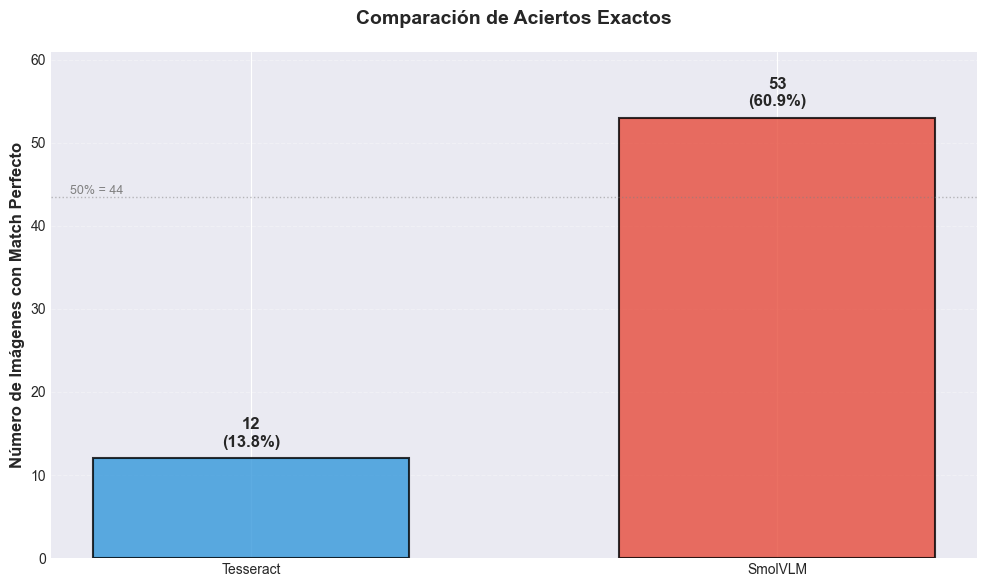

Guardado: C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\02_tiempo_promedio.png


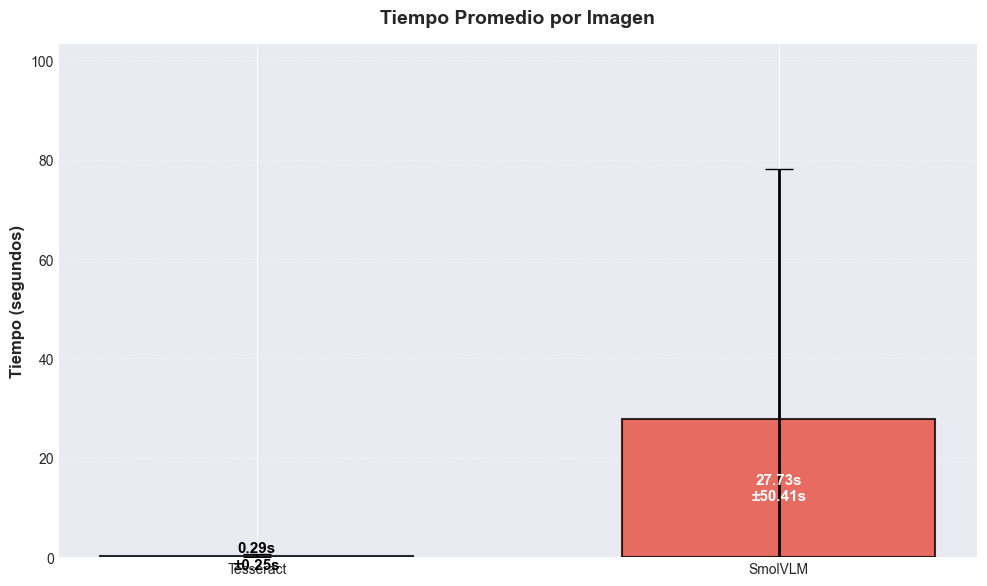

Guardado: C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\03_distancia_levenshtein.png


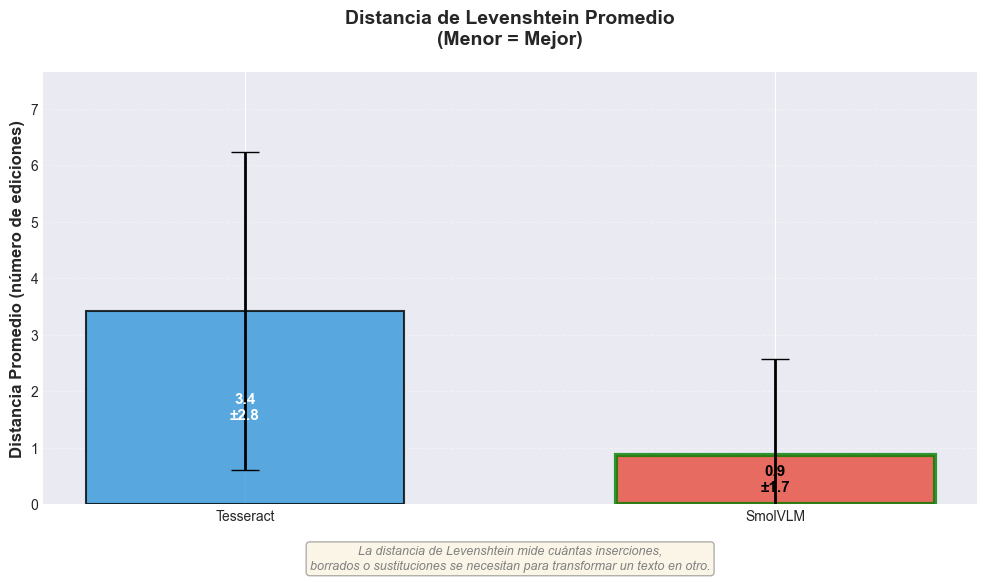

Guardado: C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\04_comparacion_completa.png


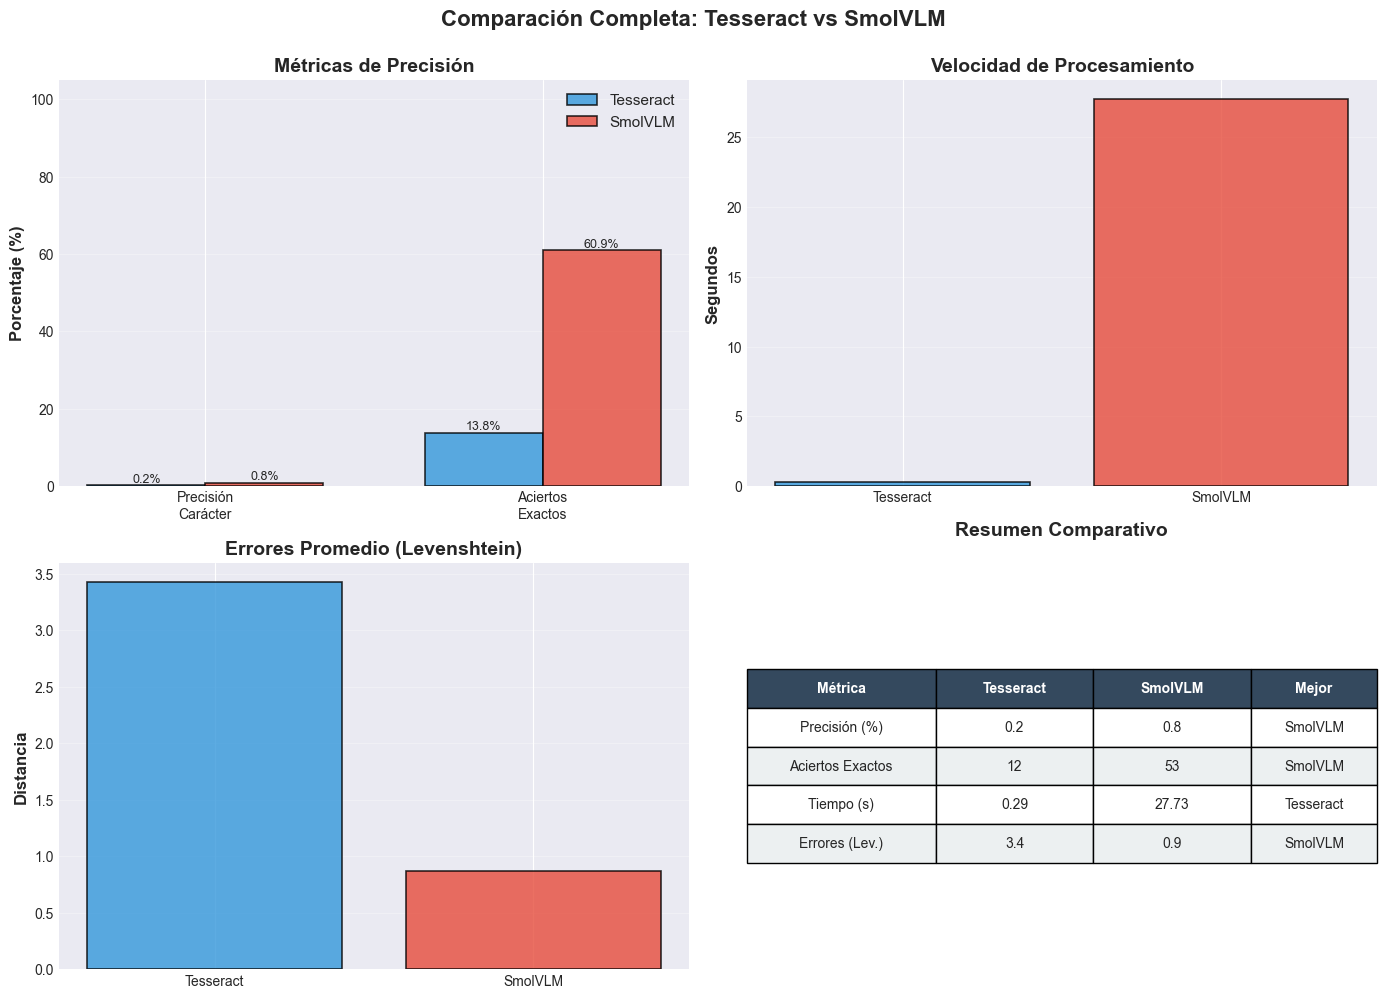

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

output_dir = Path("C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5")
output_dir.mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')
colors = ['#3498db', '#e74c3c']  # Azul para Tesseract, Rojo para SmolVLM
colors_light = ['#5dade2', '#ec7063']

plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11

fig, ax = plt.subplots(figsize=(10, 6))

method_names = ['Tesseract', 'SmolVLM']
exact_matches = [
    results_df['tesseract_exact_match'].sum(),
    results_df['smolvlm_exact_match'].sum()
]
total_images = len(results_df)
percentages = [(x/total_images)*100 for x in exact_matches]

bars = ax.bar(method_names, exact_matches, color=colors, 
              edgecolor='black', linewidth=1.5, alpha=0.8, width=0.6)

for i, (bar, val, pct) in enumerate(zip(bars, exact_matches, percentages)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(exact_matches)*0.02,
            f'{val}\n({pct:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_title('Comparación de Aciertos Exactos', fontweight='bold', pad=20)
ax.set_ylabel('Número de Imágenes con Match Perfecto', fontweight='bold')
ax.set_ylim(0, max(exact_matches) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

ax.axhline(total_images/2, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.text(0.02, total_images/2, f'50% = {total_images/2:.0f}', 
        transform=ax.get_yaxis_transform(), va='bottom', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(output_dir / '01_aciertos_exactos.png', dpi=300, bbox_inches='tight')
print(f"Guardado: {output_dir / '01_aciertos_exactos.png'}")
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

method_names = ['Tesseract', 'SmolVLM']
avg_times = [
    results_df['tesseract_time'].mean(),
    results_df['smolvlm_time'].mean()
]
std_times = [
    results_df['tesseract_time'].std(),
    results_df['smolvlm_time'].std()
]

bars = ax.bar(method_names, avg_times, color=colors, 
               edgecolor='black', linewidth=1.5, alpha=0.8, width=0.6,
               yerr=std_times, capsize=10, error_kw={'linewidth': 2})

for i, (bar, val, std) in enumerate(zip(bars, avg_times, std_times)):
    y_pos = val * 0.5 
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{val:.2f}s\n±{std:.2f}s',
             ha='center', va='center', fontweight='bold', fontsize=11,
             color='white' if val > max(avg_times)*0.3 else 'black')

ax.set_title('Tiempo Promedio por Imagen', fontweight='bold', pad=15)
ax.set_ylabel('Tiempo (segundos)', fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

ax.set_ylim(0, max(avg_times) + max(std_times) * 1.5)

plt.tight_layout()
plt.savefig(output_dir / '02_tiempo_promedio.png', dpi=300, bbox_inches='tight')
print(f"Guardado: {output_dir / '02_tiempo_promedio.png'}")
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

avg_levenshtein = [
    results_df['tesseract_levenshtein'].mean(),
    results_df['smolvlm_levenshtein'].mean()
]
std_levenshtein = [
    results_df['tesseract_levenshtein'].std(),
    results_df['smolvlm_levenshtein'].std()
]

bars = ax.bar(method_names, avg_levenshtein, color=colors, 
              edgecolor='black', linewidth=1.5, alpha=0.8, width=0.6,
              yerr=std_levenshtein, capsize=10, error_kw={'linewidth': 2})

for bar, val, std in zip(bars, avg_levenshtein, std_levenshtein):
    y_pos = val * 0.5
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{val:.1f}\n±{std:.1f}',
            ha='center', va='center', fontweight='bold', fontsize=11,
            color='white' if val > max(avg_levenshtein)*0.3 else 'black')

winner_idx = avg_levenshtein.index(min(avg_levenshtein))
bars[winner_idx].set_edgecolor('green')
bars[winner_idx].set_linewidth(3)

ax.set_title('Distancia de Levenshtein Promedio\n(Menor = Mejor)', 
             fontweight='bold', pad=20)
ax.set_ylabel('Distancia Promedio (número de ediciones)', fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

ax.set_ylim(0, max(avg_levenshtein) + max(std_levenshtein) * 1.5)

note = "La distancia de Levenshtein mide cuántas inserciones,\nborrados o sustituciones se necesitan para transformar un texto en otro."
ax.text(0.5, -0.15, note, transform=ax.transAxes, ha='center',
        fontsize=9, style='italic', color='gray',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(output_dir / '03_distancia_levenshtein.png', dpi=300, bbox_inches='tight')
print(f"Guardado: {output_dir / '03_distancia_levenshtein.png'}")
plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación Completa: Tesseract vs SmolVLM', 
             fontsize=16, fontweight='bold', y=0.995)

metrics = ['Precisión\nCarácter', 'Aciertos\nExactos']
tess_scores = [results_df['tesseract_char_accuracy'].mean(), 
               (results_df['tesseract_exact_match'].sum()/len(results_df))*100]
smol_scores = [results_df['smolvlm_char_accuracy'].mean(),
               (results_df['smolvlm_exact_match'].sum()/len(results_df))*100]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, tess_scores, width, label='Tesseract', 
                color=colors[0], alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, smol_scores, width, label='SmolVLM', 
                color=colors[1], alpha=0.8, edgecolor='black', linewidth=1.2)

ax1.set_ylabel('Porcentaje (%)', fontweight='bold')
ax1.set_title('Métricas de Precisión', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 105)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.bar(method_names, avg_times, color=colors, alpha=0.8, 
        edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Segundos', fontweight='bold')
ax2.set_title('Velocidad de Procesamiento', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

ax3.bar(method_names, avg_levenshtein, color=colors, alpha=0.8,
        edgecolor='black', linewidth=1.2)
ax3.set_ylabel('Distancia', fontweight='bold')
ax3.set_title('Errores Promedio (Levenshtein)', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

ax4.axis('tight')
ax4.axis('off')

summary_data = [
    ['Métrica', 'Tesseract', 'SmolVLM', 'Mejor'],
    ['Precisión (%)', f'{tess_scores[0]:.1f}', f'{smol_scores[0]:.1f}', 
     'Tesseract' if tess_scores[0] > smol_scores[0] else 'SmolVLM'],
    ['Aciertos Exactos', f'{exact_matches[0]}', f'{exact_matches[1]}',
     'Tesseract' if exact_matches[0] > exact_matches[1] else 'SmolVLM'],
    ['Tiempo (s)', f'{avg_times[0]:.2f}', f'{avg_times[1]:.2f}',
     'Tesseract' if avg_times[0] < avg_times[1] else 'SmolVLM'],
    ['Errores (Lev.)', f'{avg_levenshtein[0]:.1f}', f'{avg_levenshtein[1]:.1f}',
     'Tesseract' if avg_levenshtein[0] < avg_levenshtein[1] else 'SmolVLM']
]

table = ax4.table(cellText=summary_data, cellLoc='center', loc='center',
                  colWidths=[0.3, 0.25, 0.25, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(summary_data)):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')
        else:
            if j == 3:
                winner = summary_data[i][j]
                cell.set_facecolor('#d5f4e6' if winner == 'Tesseract' else '#fadbd8')
            cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')

ax4.set_title('Resumen Comparativo', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(output_dir / '04_comparacion_completa.png', dpi=300, bbox_inches='tight')
print(f"Guardado: {output_dir / '04_comparacion_completa.png'}")
plt.show()